In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


# version

In [2]:
# 기존 keras, tensorflow 삭제하기
!pip uninstall keras-nightly
!pip uninstall -y tensorflow

Uninstalling keras-nightly-2.5.0.dev2021032900:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/keras/*
    /usr/local/lib/python3.7/dist-packages/keras_nightly-2.5.0.dev2021032900.dist-info/*
  Would not remove (might be manually added):
    /usr/local/lib/python3.7/dist-packages/keras/applications/resnet50.py
    /usr/local/lib/python3.7/dist-packages/keras/engine/network.py
    /usr/local/lib/python3.7/dist-packages/keras/engine/topology.py
    /usr/local/lib/python3.7/dist-packages/keras/initializers.py
    /usr/local/lib/python3.7/dist-packages/keras/layers/experimental/__init__.py
    /usr/local/lib/python3.7/dist-packages/keras/layers/experimental/preprocessing/__init__.py
    /usr/local/lib/python3.7/dist-packages/keras/objectives.py
    /usr/local/lib/python3.7/dist-packages/keras/optimizers/__init__.py
    /usr/local/lib/python3.7/dist-packages/keras/optimizers/schedules/__init__.py
    /usr/local/lib/python3.7/dist-packages/keras/utils/test_utils.py
Proceed (y/n)?

In [3]:
!pip install keras==2.3.1
!pip install tensorflow==2.2.0

     |████████████████████████████████| 378kB 9.5MB/s 
     |████████████████████████████████| 51kB 8.6MB/s 
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3
     |████████████████████████████████| 516.2MB 31kB/s 
     |████████████████████████████████| 3.0MB 75kB/s 
     |████████████████████████████████| 460kB 42.7MB/s 
     |████████████████████████████████| 2.9MB 43.8MB/s 
  Found existing installation: tensorboard 2.5.0
    Uninstalling tensorboard-2.5.0:
      Successfully uninstalled tensorboard-2.5.0
  Found existing installation: tensorflow-estimator 2.5.0
    Uninstalling tensorflow-estimator-2.5.0:
      Successfully uninstalled tensorflow-estimator-2.5.0
  Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Successfully uninstalled gast-0.4.0


In [1]:
import tensorflow as tf
print(tf.__version__)


# 케라스 버전 확인하기
import keras
print(keras.__version__)

2.2.0
2.3.1


Using TensorFlow backend.


In [ ]:
!python --version

Python 3.7.10


In [ ]:
!pip freeze

# **CNN_SENET**

In [3]:
from keras.models import Model,  Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dropout, Dense, Activation, GlobalAveragePooling2D, Reshape, multiply, BatchNormalization, InputLayer
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.callbacks import ModelCheckpoint,EarlyStopping
import os
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
from sklearn.utils import shuffle
from keras.preprocessing import image

In [ ]:
# 데이터 불러오기
# augmentation
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
valid_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

# imageDataGenerator 디버깅 (flow())
img = load_img('/content/gdrive/MyDrive/Study/colloar_type_dataset/train/Straight/crop_SHIRT_1.jpg.jpg')  # PIL 이미지
x = img_to_array(img)  # (3, 64, 48) 크기의 NumPy 배열
x = x.reshape((1,) + x.shape)  # (1, 3, 64, 48) 크기의 NumPy 배열

# 아래 .flow() 함수는 임의 변환된 이미지를 배치 단위로 생성해서
# 지정된 `preview/` 폴더에 저장합니다.
i = 0
for batch in train_datagen.flow(x, batch_size=1,
                                save_to_dir='/content/gdrive/MyDrive/Study/colloar_type_dataset/preview',
                                save_prefix='Straight',
                                save_format='jpg'):
    i += 1
    if i > 20:
        break  # 이미지 20장을 생성하고 마칩니다

# 파일 불러오기
train_set = train_datagen.flow_from_directory('/content/gdrive/MyDrive/Study/colloar_type_dataset/train', target_size=(64, 48),
                                                 batch_size=32, class_mode='categorical')
valid_set = valid_datagen.flow_from_directory('/content/gdrive/MyDrive/Study/colloar_type_dataset/val', target_size=(64, 48),
                                              batch_size=1, class_mode = 'categorical')
test_set = test_datagen.flow_from_directory('/content/gdrive/MyDrive/Study/colloar_type_dataset/test', target_size=(64, 48),
                                            batch_size=1, class_mode = 'categorical')

Found 1214 images belonging to 3 classes.
Found 168 images belonging to 3 classes.
Found 168 images belonging to 3 classes.


***activation 하고 커널 수하고 r 값 건들이면서 시도!***

- 기존 cnn + senet
# 1. activation - seblock

In [ ]:
# SE_block
def SE_block(pre_layer, ch, r):
    # Squeeze
    x = GlobalAveragePooling2D()(pre_layer)
    # Excitation
    x = Dense(int(ch/r), activation='relu')(x)
    x = Dense(ch, activation='sigmoid')(x)
    x = Reshape((1, 1, ch))(x)
    x = multiply([pre_layer, x])

    return x

# 모델
inputs = Input(shape = (64, 48, 3))

x = Conv2D(32, (3, 3), activation = 'relu')(inputs)
x = MaxPooling2D(pool_size = (2, 2))(x)
x = Conv2D(32, (3, 3), activation = 'relu')(x)
x = SE_block(x, 32, 4)
x = MaxPooling2D(pool_size = (2, 2))(x)
x = Flatten()(x)
x = Dense(64, activation = 'relu')(x)
x = Dropout(0.5)(x)

outputs = Dense(3, activation = 'softmax')(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

# # 모델 최적화 설정
# MODEL_DIR = '/content/gdrive/MyDrive/Study/model/model_process'
# if not os.path.exists(MODEL_DIR):
#     os.mkdir(MODEL_DIR)

# modelpath="/content/gdrive/MyDrive/Study/model/model_process/{epoch:02d}-{val_loss:.4f}.hdf5"
# checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)
# early_stopping_callback = EarlyStopping(monitor='val_loss', patience=20)

# history = model.fit(train_set, epochs=100, steps_per_epoch = 100,
#                     validation_data=valid_set, validation_steps=valid_set.samples,
#                     callbacks = [early_stopping_callback, checkpointer])

history = model.fit_generator(train_set, epochs=50, steps_per_epoch = 100,
                              validation_data=valid_set, validation_steps=valid_set.samples)

# 모델 저장
model.save('/content/gdrive/MyDrive/Study/model/model_cnn-senet/cnn_senet_simple.h5')

Epoch 1/50
100/100 [==============================] - 202s 2s/step - loss: 0.9701 - accuracy: 0.5197 - val_loss: 0.4094 - val_accuracy: 0.6310
Epoch 2/50
100/100 [==============================] - 7s 69ms/step - loss: 0.8717 - accuracy: 0.5992 - val_loss: 0.5378 - val_accuracy: 0.7321
Epoch 3/50
100/100 [==============================] - 7s 73ms/step - loss: 0.8106 - accuracy: 0.6405 - val_loss: 0.7635 - val_accuracy: 0.7321
Epoch 4/50
100/100 [==============================] - 7s 73ms/step - loss: 0.7551 - accuracy: 0.6677 - val_loss: 0.1547 - val_accuracy: 0.7381
Epoch 5/50
100/100 [==============================] - 7s 74ms/step - loss: 0.7480 - accuracy: 0.6619 - val_loss: 0.3804 - val_accuracy: 0.7738
Epoch 6/50
100/100 [==============================] - 7s 74ms/step - loss: 0.7279 - accuracy: 0.6791 - val_loss: 0.1427 - val_accuracy: 0.7679
Epoch 7/50
100/100 [==============================] - 7s 74ms/step - loss: 0.7024 - accuracy: 0.6932 - val_loss: 2.9166 - val_accuracy: 0.7381

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 48, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 62, 46, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 31, 23, 32)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 29, 21, 32)   9248        max_pooling2d_1[0][0]            
____________________________________________________________________________________________

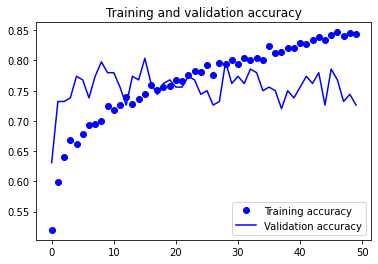

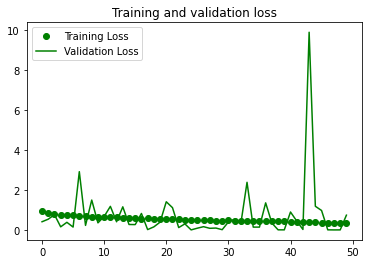

In [ ]:
# 그래프
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'go', label='Training Loss')
plt.plot(epochs, val_loss, 'g', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


 Valid Accuracy: 0.7262

 Test Accuracy: 0.7917


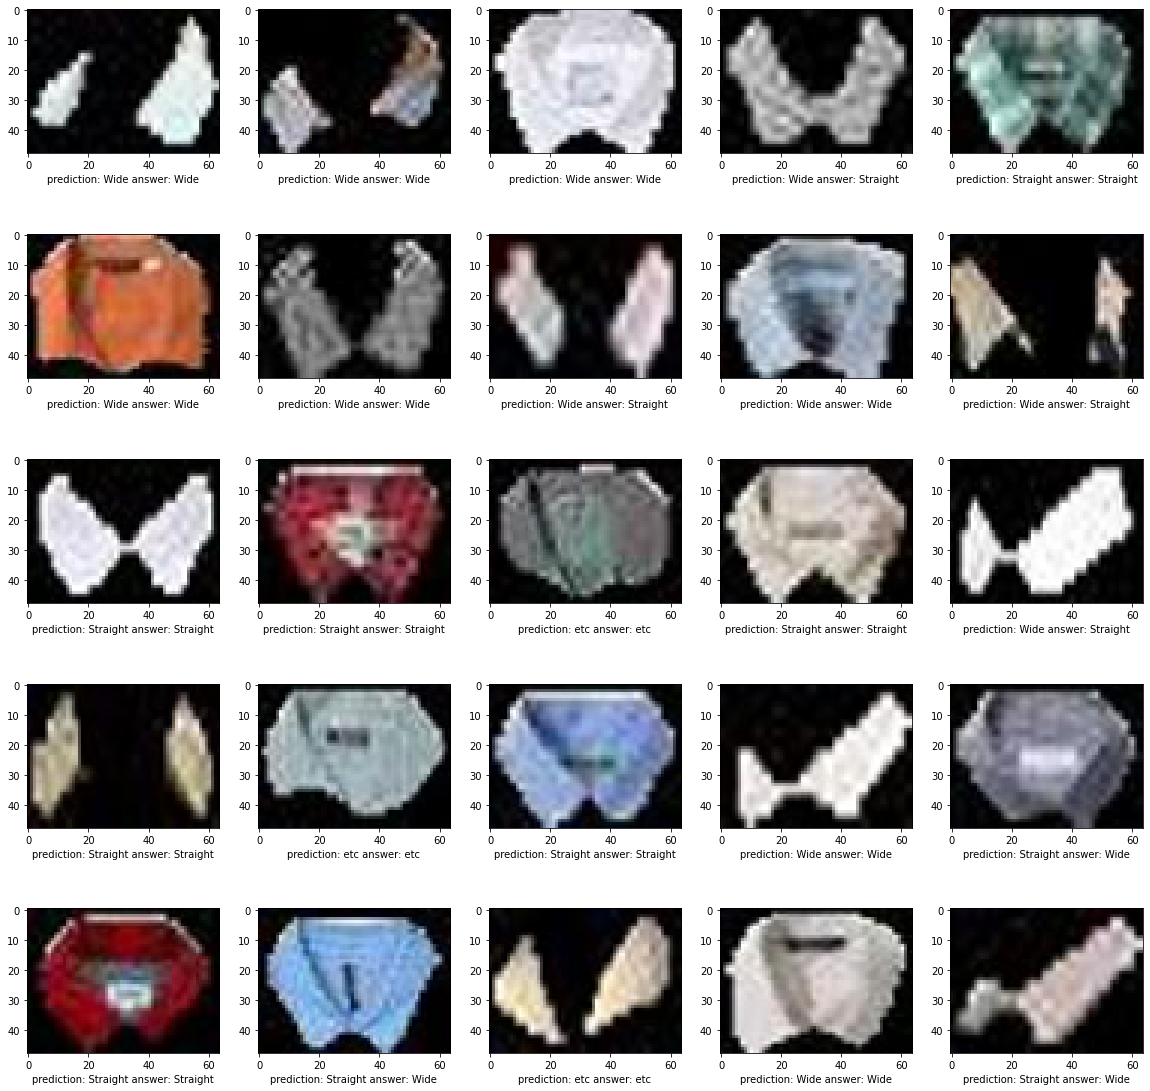

In [ ]:
# 모델
model = load_model('/content/gdrive/MyDrive/Study/model/model_cnn-senet/cnn_senet_simple.h5')

# 평가
print("\n Valid Accuracy: %.4f" % (model.evaluate_generator(valid_set)[1]))
print("\n Test Accuracy: %.4f" % (model.evaluate_generator(test_set)[1]))

#예측 (이미지, 정답&예측 그래프)
cls_index = ['Straight', 'Wide', 'etc']

plt.figure(figsize=(20,20))
for i in range(25):
    imgs = test_set[i]
    arr = imgs[0][0]
    img = array_to_img(arr).resize((64, 48))
    result = model.predict(imgs[0])
    indexP = np.argmax(result[0])
    indexA = np.argmax(imgs[1][0])
    plt.subplot(5, 5, i + 1)
    plt.imshow(img)
    plt.xlabel("prediction: {} answer: {}".format(cls_index[indexP], cls_index[indexA]))

plt.show()

- 기존 cnn + senet
# 2. seblock - activation

In [ ]:
# SE_block
def SE_block(pre_layer, ch, r):
    # Squeeze
    x = GlobalAveragePooling2D()(pre_layer)
    # Excitation
    x = Dense(int(ch/r), activation='relu')(x)
    x = Dense(ch, activation='sigmoid')(x)
    x = Reshape((1, 1, ch))(x)
    x = multiply([pre_layer, x])

    return x

# 모델
inputs = Input(shape = (64, 48, 3))

x = Conv2D(32, (3, 3), activation = 'relu')(inputs)
x = MaxPooling2D(pool_size = (2, 2))(x)
x = Conv2D(32, (3, 3), activation = None)(x)
x = SE_block(x, 32, 4)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size = (2, 2))(x)
x = Flatten()(x)
x = Dense(64, activation = 'relu')(x)
x = Dropout(0.5)(x)

outputs = Dense(3, activation = 'softmax')(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

# # 모델 최적화 설정
# MODEL_DIR = '/content/gdrive/MyDrive/Study/model/model_process'
# if not os.path.exists(MODEL_DIR):
#     os.mkdir(MODEL_DIR)

# modelpath="/content/gdrive/MyDrive/Study/model/model_process/{epoch:02d}-{val_loss:.4f}.hdf5"
# checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)
# early_stopping_callback = EarlyStopping(monitor='val_loss', patience=20)

# history = model.fit(train_set, epochs=100, steps_per_epoch = 100,
#                     validation_data=valid_set, validation_steps=valid_set.samples,
#                     callbacks = [early_stopping_callback, checkpointer])

history = model.fit_generator(train_set, epochs=50, steps_per_epoch = 100,
                              validation_data=valid_set, validation_steps=valid_set.samples)

# 모델 저장
model.save('/content/gdrive/MyDrive/Study/model/model_cnn-senet/cnn_senet_simpleA.h5')

Epoch 1/50
100/100 [==============================] - 7s 75ms/step - loss: 0.9663 - accuracy: 0.5197 - val_loss: 0.7402 - val_accuracy: 0.5952
Epoch 2/50
100/100 [==============================] - 7s 73ms/step - loss: 0.8571 - accuracy: 0.6024 - val_loss: 0.3756 - val_accuracy: 0.7143
Epoch 3/50
100/100 [==============================] - 7s 73ms/step - loss: 0.8057 - accuracy: 0.6358 - val_loss: 0.8848 - val_accuracy: 0.7321
Epoch 4/50
100/100 [==============================] - 7s 74ms/step - loss: 0.7705 - accuracy: 0.6671 - val_loss: 0.7087 - val_accuracy: 0.7321
Epoch 5/50
100/100 [==============================] - 7s 73ms/step - loss: 0.7636 - accuracy: 0.6594 - val_loss: 0.4193 - val_accuracy: 0.7321
Epoch 6/50
100/100 [==============================] - 7s 73ms/step - loss: 0.7240 - accuracy: 0.6694 - val_loss: 0.4113 - val_accuracy: 0.7619
Epoch 7/50
100/100 [==============================] - 7s 74ms/step - loss: 0.7162 - accuracy: 0.6790 - val_loss: 1.9796 - val_accuracy: 0.7500

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 64, 48, 3)    0                                            
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 62, 46, 32)   896         input_4[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_6 (MaxPooling2D)  (None, 31, 23, 32)   0           conv2d_7[0][0]                   
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 29, 21, 32)   9248        max_pooling2d_6[0][0]            
____________________________________________________________________________________________

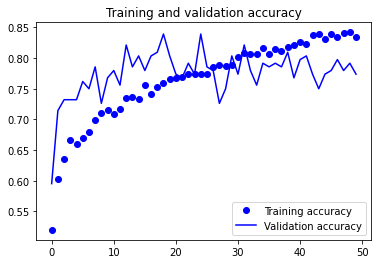

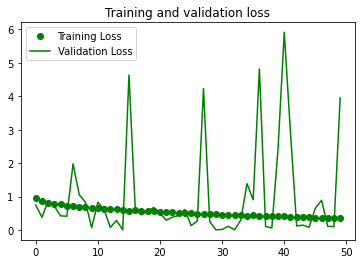

In [ ]:
# 그래프
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'go', label='Training Loss')
plt.plot(epochs, val_loss, 'g', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# 모델
model = load_model('/content/gdrive/MyDrive/Study/model/model_cnn-senet/cnn_senet_simpleA.h5')

# 평가
print("\n Valid Accuracy: %.4f" % (model.evaluate_generator(valid_set)[1]))
print("\n Test Accuracy: %.4f" % (model.evaluate_generator(test_set)[1]))


 Valid Accuracy: 0.7738

 Test Accuracy: 0.7738


# **새로운 모델**
- epoch = 50, 30
https://github.com/jhcha08/Implementation_DeepLearningPaper/blob/master/%EC%8A%A4%ED%84%B0%EB%94%94%2020200321%20-%20CNN.%20SENet.ipynb

In [ ]:
# SE_block
def SE_block(pre_layer, ch, r):
    # Squeeze
    x = GlobalAveragePooling2D()(pre_layer)
    # Excitation
    x = Dense(int(ch/r), activation='relu')(x)
    x = Dense(ch, activation='sigmoid')(x)
    x = Reshape((1, 1, ch))(x)
    x = multiply([pre_layer, x])

    return x

# 모델
inputs = Input(shape = (64, 48, 3))

x = Conv2D(32, (3, 3), strides=(1, 1), padding='same', activation = 'relu')(inputs)
x = SE_block(x, 32, 4)
x = MaxPooling2D(pool_size = (2, 2))(x)
x = Conv2D(64, (3, 3), strides=(1, 1), padding='same', activation = 'relu')(x)
x = SE_block(x, 64, 16)
x = MaxPooling2D(pool_size = (2, 2))(x)
x = Flatten()(x)
x = Dense(128, activation = 'relu')(x)

outputs = Dense(3, activation = 'softmax')(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

history = model.fit_generator(train_set, epochs=25, steps_per_epoch = 100,
                              validation_data=valid_set, validation_steps=valid_set.samples)

# 모델 저장
model.save('/content/gdrive/MyDrive/Study/model/model_cnn-senet/cnn_senet_other.h5')

In [ ]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 64, 48, 3)    0                                            
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 64, 48, 32)   896         input_5[0][0]                    
__________________________________________________________________________________________________
global_average_pooling2d_5 (Glo (None, 32)           0           conv2d_9[0][0]                   
__________________________________________________________________________________________________
dense_13 (Dense)                (None, 8)            264         global_average_pooling2d_5[0][0] 
____________________________________________________________________________________________

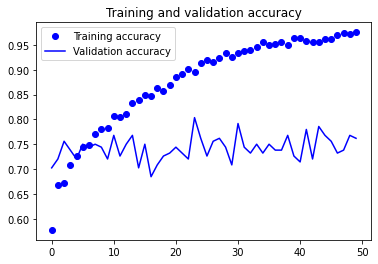

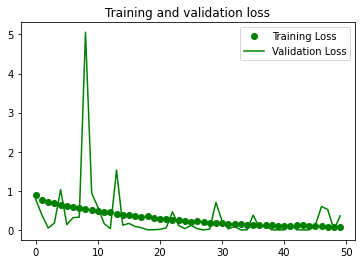

In [ ]:
# 그래프
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'go', label='Training Loss')
plt.plot(epochs, val_loss, 'g', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# 모델
model = load_model('/content/gdrive/MyDrive/Study/model/model_cnn-senet/cnn_senet_other.h5')

# 평가
print("\n Valid Accuracy: %.4f" % (model.evaluate_generator(valid_set)[1]))
print("\n Test Accuracy: %.4f" % (model.evaluate_generator(test_set)[1]))


 Valid Accuracy: 0.7619

 Test Accuracy: 0.7679


In [ ]:
# SE_block
def SE_block(pre_layer, ch, r):
    # Squeeze
    x = GlobalAveragePooling2D()(pre_layer)
    # Excitation
    x = Dense(int(ch/r), activation='relu')(x)
    x = Dense(ch, activation='sigmoid')(x)
    x = Reshape((1, 1, ch))(x)
    x = multiply([pre_layer, x])

    return x

# 모델
inputs = Input(shape = (64, 48, 3))

x = Conv2D(32, (3, 3), strides=(1, 1), padding='same', activation = 'relu')(inputs)
x = SE_block(x, 32, 4)
x = MaxPooling2D(pool_size = (2, 2))(x)
x = Conv2D(64, (3, 3), strides=(1, 1), padding='same', activation = 'relu')(x)
x = SE_block(x, 64, 16)
x = MaxPooling2D(pool_size = (2, 2))(x)
x = Flatten()(x)
x = Dense(128, activation = 'relu')(x)

outputs = Dense(3, activation = 'softmax')(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

history = model.fit_generator(train_set, epochs=25, steps_per_epoch = 100,
                              validation_data=valid_set, validation_steps=valid_set.samples)

# 모델 저장
model.save('/content/gdrive/MyDrive/Study/model/model_cnn-senet/cnn_senet_other_30.h5') # 이름은 30이지만 25번 돌림

Epoch 1/25
100/100 [==============================] - 7s 73ms/step - loss: 0.9021 - accuracy: 0.5632 - val_loss: 0.1827 - val_accuracy: 0.6250
Epoch 2/25
100/100 [==============================] - 7s 73ms/step - loss: 0.8005 - accuracy: 0.6290 - val_loss: 0.9676 - val_accuracy: 0.7440
Epoch 3/25
100/100 [==============================] - 7s 71ms/step - loss: 0.7286 - accuracy: 0.6827 - val_loss: 1.0750 - val_accuracy: 0.7619
Epoch 4/25
100/100 [==============================] - 7s 71ms/step - loss: 0.6852 - accuracy: 0.6985 - val_loss: 0.4231 - val_accuracy: 0.7321
Epoch 5/25
100/100 [==============================] - 7s 72ms/step - loss: 0.6530 - accuracy: 0.7175 - val_loss: 0.4068 - val_accuracy: 0.7619
Epoch 6/25
100/100 [==============================] - 7s 74ms/step - loss: 0.6075 - accuracy: 0.7426 - val_loss: 0.0869 - val_accuracy: 0.7381
Epoch 7/25
100/100 [==============================] - 7s 73ms/step - loss: 0.5804 - accuracy: 0.7575 - val_loss: 0.0855 - val_accuracy: 0.7798

In [ ]:
# 모델
model = load_model('/content/gdrive/MyDrive/Study/model/model_cnn-senet/cnn_senet_other_30.h5')

# 평가
print("\n Valid Accuracy: %.4f" % (model.evaluate_generator(valid_set)[1]))
print("\n Test Accuracy: %.4f" % (model.evaluate_generator(test_set)[1]))


 Valid Accuracy: 0.7262

 Test Accuracy: 0.7917


In [ ]:
# SE_block
def SE_block(pre_layer, ch, r):
    # Squeeze
    x = GlobalAveragePooling2D()(pre_layer)
    # Excitation
    x = Dense(int(ch/r), activation='relu')(x)
    x = Dense(ch, activation='sigmoid')(x)
    x = Reshape((1, 1, ch))(x)
    x = multiply([pre_layer, x])

    return x

# 모델
inputs = Input(shape = (64, 48, 3))

x = Conv2D(32, (3, 3), strides=(1, 1), padding='same', activation = 'relu')(inputs)
x = SE_block(x, 32, 4)
x = MaxPooling2D(pool_size = (2, 2))(x)
x = Conv2D(64, (3, 3), strides=(1, 1), padding='same', activation = 'relu')(x)
x = SE_block(x, 64, 16)
x = MaxPooling2D(pool_size = (2, 2))(x)
x = Flatten()(x)
x = Dense(128, activation = 'relu')(x)

outputs = Dense(3, activation = 'softmax')(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

history = model.fit_generator(train_set, epochs=30, steps_per_epoch = 200,
                              validation_data=valid_set, validation_steps=valid_set.samples)

# 모델 저장
model.save('/content/gdrive/MyDrive/Study/model/model_cnn-senet/cnn_senet_other_30_200.h5') 

Epoch 1/30
200/200 [==============================] - 14s 70ms/step - loss: 0.8561 - accuracy: 0.5991 - val_loss: 0.4573 - val_accuracy: 0.6964
Epoch 2/30
200/200 [==============================] - 14s 69ms/step - loss: 0.7119 - accuracy: 0.6918 - val_loss: 0.0383 - val_accuracy: 0.7857
Epoch 3/30
200/200 [==============================] - 14s 70ms/step - loss: 0.6345 - accuracy: 0.7336 - val_loss: 0.1972 - val_accuracy: 0.7321
Epoch 4/30
200/200 [==============================] - 14s 69ms/step - loss: 0.5794 - accuracy: 0.7528 - val_loss: 0.0715 - val_accuracy: 0.6786
Epoch 5/30
200/200 [==============================] - 14s 70ms/step - loss: 0.5324 - accuracy: 0.7785 - val_loss: 0.5670 - val_accuracy: 0.7798
Epoch 6/30
200/200 [==============================] - 14s 69ms/step - loss: 0.4978 - accuracy: 0.7877 - val_loss: 0.1421 - val_accuracy: 0.7976
Epoch 7/30
200/200 [==============================] - 14s 69ms/step - loss: 0.4480 - accuracy: 0.8179 - val_loss: 0.1711 - val_accuracy:

In [ ]:
# 모델
model = load_model('/content/gdrive/MyDrive/Study/model/model_cnn-senet/cnn_senet_other_30_200.h5')

# 평가
print("\n Valid Accuracy: %.4f" % (model.evaluate_generator(valid_set)[1]))
print("\n Test Accuracy: %.4f" % (model.evaluate_generator(test_set)[1]))


 Valid Accuracy: 0.7321

 Test Accuracy: 0.7798


# **새로운 모델2**

In [ ]:
# SE_block
def SE_block(pre_layer, ch, r):
    # Squeeze
    x = GlobalAveragePooling2D()(pre_layer)
    # Excitation
    x = Dense(int(ch/r), activation='relu')(x)
    x = Dense(ch, activation='sigmoid')(x)
    x = Reshape((1, 1, ch))(x)
    x = multiply([pre_layer, x])

    return x

# 모델
inputs = Input(shape = (64, 48, 3))

x = Conv2D(32, (3, 3), strides=(1, 1), padding='same', activation = 'relu')(inputs)
x = MaxPooling2D(pool_size = (2, 2))(x)
x = Conv2D(64, (3, 3), strides=(1, 1), padding='same', activation = None)(x)
x = BatchNormalization()(x)
x = SE_block(x, 64, 16)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size = (2, 2))(x)
x = Flatten()(x)
x = Dense(128, activation = 'relu')(x)

outputs = Dense(3, activation = 'softmax')(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

history = model.fit_generator(train_set, epochs=50, steps_per_epoch = 100,
                              validation_data=valid_set, validation_steps=valid_set.samples)

# 모델 저장
model.save('/content/gdrive/MyDrive/Study/model/model_cnn-senet/cnn_senet_other2.h5')

Epoch 1/50
100/100 [==============================] - 416s 4s/step - loss: 1.1601 - accuracy: 0.5304 - val_loss: 1.0695 - val_accuracy: 0.5536
Epoch 2/50
100/100 [==============================] - 7s 68ms/step - loss: 0.8323 - accuracy: 0.5929 - val_loss: 1.1003 - val_accuracy: 0.6964
Epoch 3/50
100/100 [==============================] - 7s 73ms/step - loss: 0.7814 - accuracy: 0.6403 - val_loss: 0.8398 - val_accuracy: 0.7381
Epoch 4/50
100/100 [==============================] - 7s 73ms/step - loss: 0.7487 - accuracy: 0.6514 - val_loss: 0.4195 - val_accuracy: 0.7679
Epoch 5/50
100/100 [==============================] - 7s 73ms/step - loss: 0.7174 - accuracy: 0.6832 - val_loss: 0.8263 - val_accuracy: 0.6369
Epoch 6/50
100/100 [==============================] - 7s 72ms/step - loss: 0.6826 - accuracy: 0.7113 - val_loss: 0.2629 - val_accuracy: 0.7202
Epoch 7/50
100/100 [==============================] - 7s 73ms/step - loss: 0.6416 - accuracy: 0.7344 - val_loss: 1.1010 - val_accuracy: 0.7440

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 64, 48, 3)    0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 64, 48, 32)   896         input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 32, 24, 32)   0           conv2d_3[0][0]                   
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 32, 24, 64)   18496       max_pooling2d_2[0][0]            
____________________________________________________________________________________________

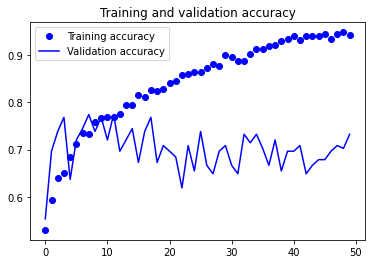

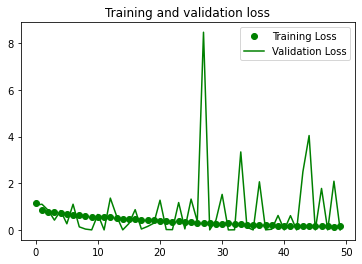

In [ ]:
# 그래프
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'go', label='Training Loss')
plt.plot(epochs, val_loss, 'g', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# 모델
model = load_model('/content/gdrive/MyDrive/Study/model/model_cnn-senet/cnn_senet_other2.h5')

# 평가
print("\n Valid Accuracy: %.4f" % (model.evaluate_generator(valid_set)[1]))
print("\n Test Accuracy: %.4f" % (model.evaluate_generator(test_set)[1]))


 Valid Accuracy: 0.7321

 Test Accuracy: 0.7440


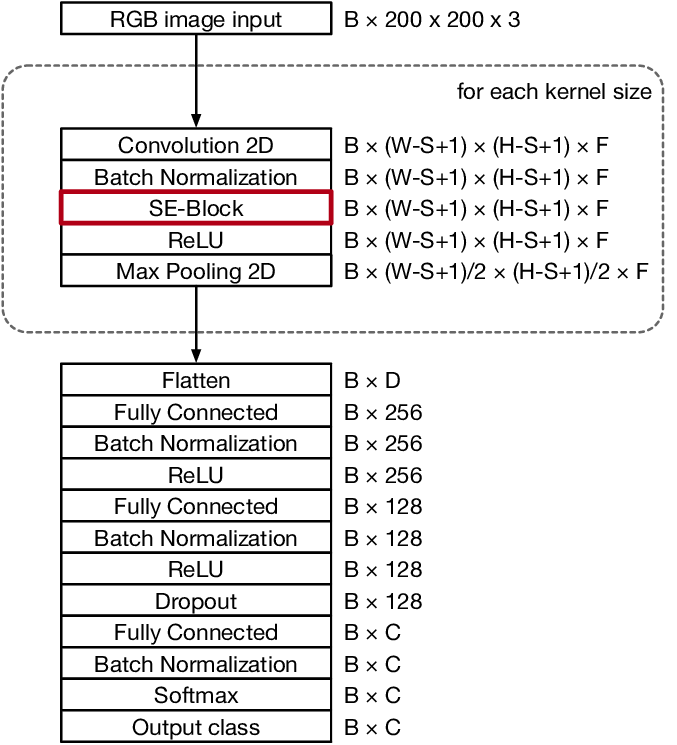

In [ ]:
# SE_block
def SE_block(pre_layer, ch, r):
    # Squeeze
    x = GlobalAveragePooling2D()(pre_layer)
    # Excitation
    x = Dense(int(ch/r), activation='relu')(x)
    x = Dense(ch, activation='sigmoid')(x)
    x = Reshape((1, 1, ch))(x)
    x = multiply([pre_layer, x])

    return x

# 모델
inputs = Input(shape = (64, 48, 3))

x = Conv2D(32, (3, 3), strides=(1, 1), padding='same', activation = None)(inputs)
x = BatchNormalization()(x)
x = SE_block(x, 32, 16)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size = (2, 2))(x)
x = Flatten()(x)
x = Dense(128)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dense(64)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

outputs = Dense(3, activation = 'softmax')(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

history = model.fit_generator(train_set, epochs=30, steps_per_epoch = 100,
                              validation_data=valid_set, validation_steps=valid_set.samples)

# 모델 저장
model.save('/content/gdrive/MyDrive/Study/model/model_cnn-senet/cnn_senet_other_B.h5')

Epoch 1/30
100/100 [==============================] - 8s 79ms/step - loss: 0.9445 - accuracy: 0.5570 - val_loss: 0.3088 - val_accuracy: 0.2798
Epoch 2/30
100/100 [==============================] - 7s 74ms/step - loss: 0.7422 - accuracy: 0.6593 - val_loss: 0.6521 - val_accuracy: 0.5774
Epoch 3/30
100/100 [==============================] - 7s 74ms/step - loss: 0.7048 - accuracy: 0.6803 - val_loss: 0.3429 - val_accuracy: 0.6131
Epoch 4/30
100/100 [==============================] - 7s 74ms/step - loss: 0.6704 - accuracy: 0.7049 - val_loss: 1.2607 - val_accuracy: 0.7262
Epoch 5/30
100/100 [==============================] - 8s 75ms/step - loss: 0.6206 - accuracy: 0.7279 - val_loss: 0.4580 - val_accuracy: 0.7262
Epoch 6/30
100/100 [==============================] - 7s 74ms/step - loss: 0.5801 - accuracy: 0.7480 - val_loss: 0.0850 - val_accuracy: 0.7143
Epoch 7/30
100/100 [==============================] - 8s 76ms/step - loss: 0.5723 - accuracy: 0.7522 - val_loss: 0.5722 - val_accuracy: 0.5298

In [ ]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 64, 48, 3)    0                                            
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 64, 48, 32)   896         input_8[0][0]                    
__________________________________________________________________________________________________
batch_normalization_5 (BatchNor (None, 64, 48, 32)   128         conv2d_14[0][0]                  
__________________________________________________________________________________________________
global_average_pooling2d_11 (Gl (None, 32)           0           batch_normalization_5[0][0]      
____________________________________________________________________________________________

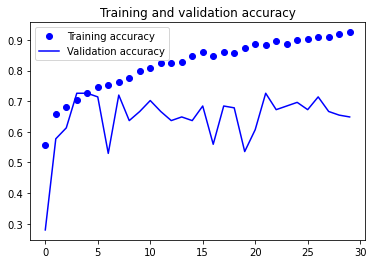

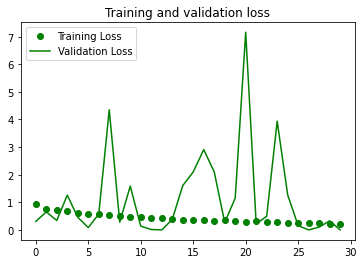

In [ ]:
# 그래프
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'go', label='Training Loss')
plt.plot(epochs, val_loss, 'g', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# 모델
model = load_model('/content/gdrive/MyDrive/Study/model/model_cnn-senet/cnn_senet_other_B.h5')

# 평가
print("\n Valid Accuracy: %.4f" % (model.evaluate_generator(valid_set)[1]))
print("\n Test Accuracy: %.4f" % (model.evaluate_generator(test_set)[1]))


 Valid Accuracy: 0.6488

 Test Accuracy: 0.7202


# **투명 이미지 데이터 이용**

- img_size = (100, 50)

Found 1345 images belonging to 3 classes.
Found 167 images belonging to 3 classes.
Found 167 images belonging to 3 classes.
Epoch 1/30
225/224 [==============================] - 35s 154ms/step - loss: 0.9310 - acc: 0.5615 - val_loss: 0.9938 - val_acc: 0.5689
Epoch 2/30
225/224 [==============================] - 33s 147ms/step - loss: 0.8839 - acc: 0.5853 - val_loss: 1.0196 - val_acc: 0.6407
Epoch 3/30
225/224 [==============================] - 34s 151ms/step - loss: 0.8009 - acc: 0.6192 - val_loss: 0.7701 - val_acc: 0.5928
Epoch 4/30
225/224 [==============================] - 34s 151ms/step - loss: 0.7545 - acc: 0.6315 - val_loss: 0.6098 - val_acc: 0.6587
Epoch 5/30
225/224 [==============================] - 34s 152ms/step - loss: 0.6964 - acc: 0.6527 - val_loss: 0.5019 - val_acc: 0.7186
Epoch 6/30
225/224 [==============================] - 34s 150ms/step - loss: 0.6718 - acc: 0.6715 - val_loss: 0.6338 - val_acc: 0.6946
Epoch 7/30
225/224 [==============================] - 34s 151ms/st

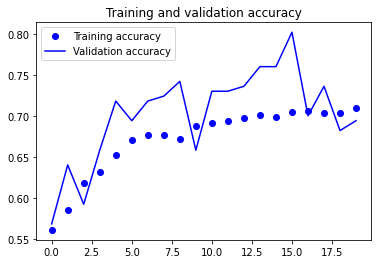

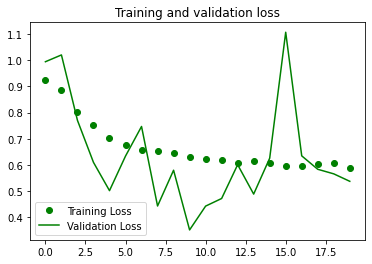

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

rootPath = '/content/gdrive/MyDrive/Study/collars_500x600_crop'
img_size = (100, 50)

imageGenerator = ImageDataGenerator(
    rescale=1. / 255,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[.2, .2],
    horizontal_flip=True,
)

trainGen = imageGenerator.flow_from_directory(os.path.join(rootPath, 'train'), class_mode='categorical',
                                              target_size=img_size, shuffle=True,
                                              color_mode='rgba')

valGenerator = ImageDataGenerator(rescale=1. / 255)

valGen = valGenerator.flow_from_directory(os.path.join(rootPath, 'val'), class_mode='categorical',
                                          target_size=img_size, shuffle=True,
                                          color_mode='rgba')

testGenerator = ImageDataGenerator(rescale=1. / 255)

testGen = testGenerator.flow_from_directory(os.path.join(rootPath, 'test'), class_mode='categorical',
                                            target_size=img_size, shuffle=True,
                                            color_mode='rgba')

# x, y = trainGen.next()
# print(x[0].shape)
# plt.imshow(x[0])
# plt.show()

model = Sequential()

model.add(InputLayer(input_shape=(img_size + (4,))))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

epochs = 30
history = model.fit_generator(trainGen,
                              epochs=epochs,
                              steps_per_epoch=trainGen.samples / epochs * 5,
                              validation_data=valGen,
                              validation_steps=valGen.samples / epochs,
                              callbacks=[early_stopping])

print("\n Valid Accuracy: %.4f" % (model.evaluate_generator(valGen)[1]))
print("\n Test Accuracy: %.4f" % (model.evaluate_generator(testGen)[1]))

# graph
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'go', label='Training Loss')
plt.plot(epochs, val_loss, 'g', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

model.save('/content/gdrive/MyDrive/Study/model/model_cnn-senet/cnn_alpha.h5') # 아래꺼에 의해 덮어짐...

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 98, 48, 32)        1184      
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 49, 24, 32)        0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 49, 24, 32)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 47, 22, 64)        18496     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 23, 11, 64)        0         
_________________________________________________________________
dropout_23 (Dropout)         (None, 23, 11, 64)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 21, 9, 128)       

- img_size = (90, 50)

Found 1345 images belonging to 3 classes.
Found 167 images belonging to 3 classes.
Found 167 images belonging to 3 classes.
Epoch 1/50
135/134 [==============================] - 20s 151ms/step - loss: 0.9155 - acc: 0.5628 - val_loss: 0.9449 - val_acc: 0.5312
Epoch 2/50
135/134 [==============================] - 20s 146ms/step - loss: 0.8997 - acc: 0.5761 - val_loss: 0.6813 - val_acc: 0.7476
Epoch 3/50
135/134 [==============================] - 20s 145ms/step - loss: 0.8863 - acc: 0.5934 - val_loss: 0.7883 - val_acc: 0.5728
Epoch 4/50
135/134 [==============================] - 20s 148ms/step - loss: 0.8583 - acc: 0.6092 - val_loss: 1.1621 - val_acc: 0.6562
Epoch 5/50
135/134 [==============================] - 20s 151ms/step - loss: 0.8830 - acc: 0.5976 - val_loss: 0.7320 - val_acc: 0.5631
Epoch 6/50
135/134 [==============================] - 19s 144ms/step - loss: 0.8587 - acc: 0.6075 - val_loss: 1.7258 - val_acc: 0.5631
Epoch 7/50
135/134 [==============================] - 20s 148ms/st

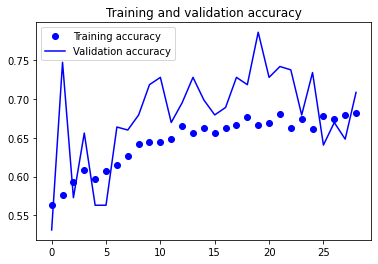

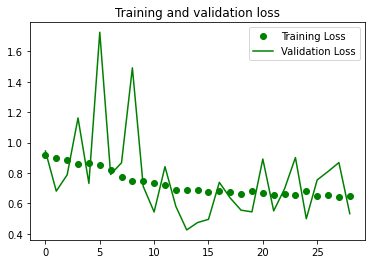

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1)

rootPath = '/content/gdrive/MyDrive/Study/collars_500x600_crop'
img_size = (90, 50)

imageGenerator = ImageDataGenerator(
    rescale=1. / 255,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[.2, .2],
    horizontal_flip=True,
)

trainGen = imageGenerator.flow_from_directory(os.path.join(rootPath, 'train'), class_mode='categorical',
                                              target_size=img_size, shuffle=True,
                                              color_mode='rgba')

valGenerator = ImageDataGenerator(rescale=1. / 255)

valGen = valGenerator.flow_from_directory(os.path.join(rootPath, 'val'), class_mode='categorical',
                                          target_size=img_size, shuffle=True,
                                          color_mode='rgba')

testGenerator = ImageDataGenerator(rescale=1. / 255)

testGen = testGenerator.flow_from_directory(os.path.join(rootPath, 'test'), class_mode='categorical',
                                            target_size=img_size, shuffle=True,
                                            color_mode='rgba')

# x, y = trainGen.next()
# print(x[0].shape)
# plt.imshow(x[0])
# plt.show()

model = Sequential()

model.add(InputLayer(input_shape=(img_size + (4,))))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

epochs = 50
history = model.fit_generator(trainGen,
                              epochs=epochs,
                              steps_per_epoch=trainGen.samples / epochs * 5,
                              validation_data=valGen,
                              validation_steps=valGen.samples / epochs,
                              callbacks=[early_stopping])

print("\n Valid Accuracy: %.4f" % (model.evaluate_generator(valGen)[1]))
print("\n Test Accuracy: %.4f" % (model.evaluate_generator(testGen)[1]))

# graph
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'go', label='Training Loss')
plt.plot(epochs, val_loss, 'g', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

model.save('/content/gdrive/MyDrive/Study/model/model_cnn-senet/cnn_alpha.h5')

**img_size = (100, 50) 으로 ㄱㄱ**

- senet

Found 1345 images belonging to 3 classes.
Found 167 images belonging to 3 classes.
Found 167 images belonging to 3 classes.
Epoch 1/30
225/224 [==============================] - 35s 155ms/step - loss: 0.9081 - acc: 0.5649 - val_loss: 1.0147 - val_acc: 0.6287
Epoch 2/30
225/224 [==============================] - 34s 153ms/step - loss: 0.8634 - acc: 0.5945 - val_loss: 0.8830 - val_acc: 0.6287
Epoch 3/30
225/224 [==============================] - 34s 152ms/step - loss: 0.7886 - acc: 0.6223 - val_loss: 0.5679 - val_acc: 0.6347
Epoch 4/30
225/224 [==============================] - 34s 152ms/step - loss: 0.7275 - acc: 0.6309 - val_loss: 0.7973 - val_acc: 0.6766
Epoch 5/30
225/224 [==============================] - 34s 151ms/step - loss: 0.6935 - acc: 0.6534 - val_loss: 0.7402 - val_acc: 0.6826
Epoch 6/30
225/224 [==============================] - 34s 152ms/step - loss: 0.6558 - acc: 0.6727 - val_loss: 0.6683 - val_acc: 0.7246
Epoch 7/30
225/224 [==============================] - 35s 154ms/st

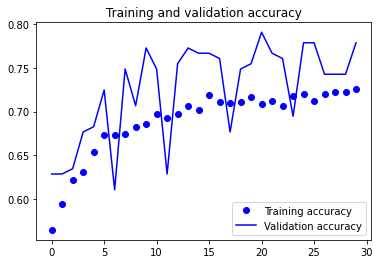

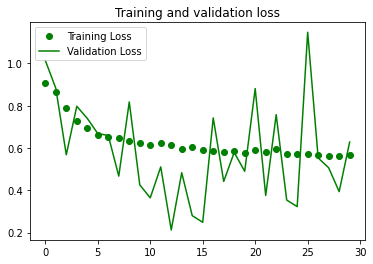

In [ ]:
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

rootPath = '/content/gdrive/MyDrive/Study/collars_500x600_crop'
img_size = (100, 50)

imageGenerator = ImageDataGenerator(
    rescale=1. / 255,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[.2, .2],
    horizontal_flip=True,
)

trainGen = imageGenerator.flow_from_directory(os.path.join(rootPath, 'train'), class_mode='categorical',
                                              target_size=img_size, shuffle=True,
                                              color_mode='rgba')

valGenerator = ImageDataGenerator(rescale=1. / 255)

valGen = valGenerator.flow_from_directory(os.path.join(rootPath, 'val'), class_mode='categorical',
                                          target_size=img_size, shuffle=True,
                                          color_mode='rgba')

testGenerator = ImageDataGenerator(rescale=1. / 255)

testGen = testGenerator.flow_from_directory(os.path.join(rootPath, 'test'), class_mode='categorical',
                                            target_size=img_size, shuffle=True,
                                            color_mode='rgba')

# x, y = trainGen.next()
# print(x[0].shape)
# plt.imshow(x[0])
# plt.show()
# SE_block
def SE_block(pre_layer, ch, r):
    # Squeeze
    x = GlobalAveragePooling2D()(pre_layer)
    # Excitation
    x = Dense(int(ch/r), activation='relu')(x)
    x = Dense(ch, activation='sigmoid')(x)
    x = Reshape((1, 1, ch))(x)
    x = multiply([pre_layer, x])

    return x

inputs = Input(shape=(img_size + (4,)))
x = Conv2D(32, (3, 3), activation='relu')(inputs)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.5)(x)

x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.5)(x)

x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.5)(x)

x = Conv2D(128, (3, 3), activation='relu')(x)
x = SE_block(x, 128, 32)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.5)(x)

x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
outputs = Dense(3, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

epochs = 30
# history = model.fit_generator(trainGen,
#                               epochs=epochs,
#                               steps_per_epoch=trainGen.samples / epochs * 5,
#                               validation_data=valGen,
#                               validation_steps=valGen.samples / epochs,
#                               callbacks=[early_stopping])
history = model.fit_generator(trainGen,
                              epochs=epochs,
                              steps_per_epoch=trainGen.samples / epochs * 5,
                              validation_data=valGen,
                              validation_steps=valGen.samples / epochs)

print("\n Valid Accuracy: %.4f" % (model.evaluate_generator(valGen)[1]))
print("\n Test Accuracy: %.4f" % (model.evaluate_generator(testGen)[1]))

# graph
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'go', label='Training Loss')
plt.plot(epochs, val_loss, 'g', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

model.save('/content/gdrive/MyDrive/Study/model/model_cnn-senet/cnn_senet_alpha.h5')

In [ ]:
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           (None, 100, 50, 4)   0                                            
__________________________________________________________________________________________________
conv2d_57 (Conv2D)              (None, 98, 48, 32)   1184        input_19[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_54 (MaxPooling2D) (None, 49, 24, 32)   0           conv2d_57[0][0]                  
__________________________________________________________________________________________________
dropout_47 (Dropout)            (None, 49, 24, 32)   0           max_pooling2d_54[0][0]           
____________________________________________________________________________________________

- conv 블록 하나 삭제하고 conv 마다 senet 추가

Found 1345 images belonging to 3 classes.
Found 167 images belonging to 3 classes.
Found 167 images belonging to 3 classes.
Epoch 1/30
225/224 [==============================] - 36s 160ms/step - loss: 0.8769 - acc: 0.5813 - val_loss: 0.7131 - val_acc: 0.5988
Epoch 2/30
225/224 [==============================] - 35s 156ms/step - loss: 0.7549 - acc: 0.6294 - val_loss: 0.6362 - val_acc: 0.6287
Epoch 3/30
225/224 [==============================] - 35s 157ms/step - loss: 0.6884 - acc: 0.6609 - val_loss: 0.8647 - val_acc: 0.7186
Epoch 4/30
225/224 [==============================] - 35s 156ms/step - loss: 0.6859 - acc: 0.6651 - val_loss: 0.6806 - val_acc: 0.7246
Epoch 5/30
225/224 [==============================] - 35s 157ms/step - loss: 0.6269 - acc: 0.6913 - val_loss: 0.4102 - val_acc: 0.7305
Epoch 6/30
225/224 [==============================] - 35s 157ms/step - loss: 0.6378 - acc: 0.6920 - val_loss: 0.3082 - val_acc: 0.7246
Epoch 7/30
225/224 [==============================] - 35s 156ms/st

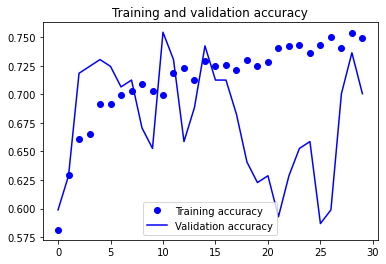

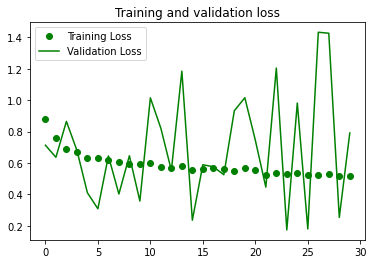

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

rootPath = '/content/gdrive/MyDrive/Study/collars_500x600_crop'
img_size = (100, 50)

imageGenerator = ImageDataGenerator(
    rescale=1. / 255,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[.2, .2],
    horizontal_flip=True,
)

trainGen = imageGenerator.flow_from_directory(os.path.join(rootPath, 'train'), class_mode='categorical',
                                              target_size=img_size, shuffle=True,
                                              color_mode='rgba')

valGenerator = ImageDataGenerator(rescale=1. / 255)

valGen = valGenerator.flow_from_directory(os.path.join(rootPath, 'val'), class_mode='categorical',
                                          target_size=img_size, shuffle=True,
                                          color_mode='rgba')

testGenerator = ImageDataGenerator(rescale=1. / 255)

testGen = testGenerator.flow_from_directory(os.path.join(rootPath, 'test'), class_mode='categorical',
                                            target_size=img_size, shuffle=True,
                                            color_mode='rgba')

# x, y = trainGen.next()
# print(x[0].shape)
# plt.imshow(x[0])
# plt.show()
# SE_block
def SE_block(pre_layer, ch, r):
    # Squeeze
    x = GlobalAveragePooling2D()(pre_layer)
    # Excitation
    x = Dense(int(ch/r), activation='relu')(x)
    x = Dense(ch, activation='sigmoid')(x)
    x = Reshape((1, 1, ch))(x)
    x = multiply([pre_layer, x])

    return x

inputs = Input(shape=(img_size + (4,)))
x = Conv2D(32, (3, 3), activation='relu')(inputs)
x = SE_block(x, 32, 8)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.5)(x)

x = Conv2D(64, (3, 3), activation='relu')(x)
x = SE_block(x, 64, 16)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.5)(x)

x = Conv2D(128, (3, 3), activation='relu')(x)
x = SE_block(x, 128, 32)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.5)(x)

x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
outputs = Dense(3, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

epochs = 30
history = model.fit_generator(trainGen,
                              epochs=epochs,
                              steps_per_epoch=trainGen.samples / epochs * 5,
                              validation_data=valGen,
                              validation_steps=valGen.samples / epochs,
                              callbacks=[early_stopping])


print("\n Valid Accuracy: %.4f" % (model.evaluate_generator(valGen)[1]))
print("\n Test Accuracy: %.4f" % (model.evaluate_generator(testGen)[1]))

# graph
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'go', label='Training Loss')
plt.plot(epochs, val_loss, 'g', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

model.save('/content/gdrive/MyDrive/Study/model/model_cnn-senet/cnn_senet_alpha_all2.h5')

In [ ]:
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           (None, 100, 50, 4)   0                                            
__________________________________________________________________________________________________
conv2d_61 (Conv2D)              (None, 98, 48, 32)   1184        input_20[0][0]                   
__________________________________________________________________________________________________
global_average_pooling2d_23 (Gl (None, 32)           0           conv2d_61[0][0]                  
__________________________________________________________________________________________________
dense_93 (Dense)                (None, 4)            132         global_average_pooling2d_23[0][0]
____________________________________________________________________________________________

- 위에꺼에 batchnormalization_별로였음

- conv 블록 다시 하나 늘림

Found 1345 images belonging to 3 classes.
Found 167 images belonging to 3 classes.
Found 167 images belonging to 3 classes.
Epoch 1/30
225/224 [==============================] - 35s 157ms/step - loss: 0.9085 - acc: 0.5655 - val_loss: 0.7057 - val_acc: 0.5689
Epoch 2/30
225/224 [==============================] - 35s 156ms/step - loss: 0.8684 - acc: 0.5946 - val_loss: 0.8833 - val_acc: 0.5988
Epoch 3/30
225/224 [==============================] - 35s 155ms/step - loss: 0.8154 - acc: 0.6070 - val_loss: 0.6902 - val_acc: 0.6826
Epoch 4/30
225/224 [==============================] - 35s 157ms/step - loss: 0.7391 - acc: 0.6280 - val_loss: 0.5318 - val_acc: 0.7126
Epoch 5/30
225/224 [==============================] - 35s 156ms/step - loss: 0.7205 - acc: 0.6420 - val_loss: 0.4480 - val_acc: 0.7006
Epoch 6/30
225/224 [==============================] - 35s 157ms/step - loss: 0.6839 - acc: 0.6735 - val_loss: 0.4659 - val_acc: 0.7186
Epoch 7/30
225/224 [==============================] - 35s 155ms/st

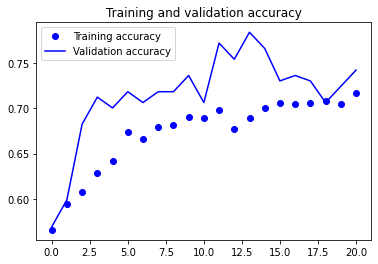

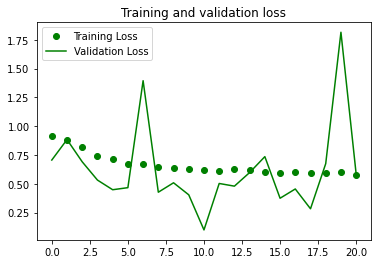

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

rootPath = '/content/gdrive/MyDrive/Study/collars_500x600_crop'
img_size = (100, 50)

imageGenerator = ImageDataGenerator(
    rescale=1. / 255,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[.2, .2],
    horizontal_flip=True,
)

trainGen = imageGenerator.flow_from_directory(os.path.join(rootPath, 'train'), class_mode='categorical',
                                              target_size=img_size, shuffle=True,
                                              color_mode='rgba')

valGenerator = ImageDataGenerator(rescale=1. / 255)

valGen = valGenerator.flow_from_directory(os.path.join(rootPath, 'val'), class_mode='categorical',
                                          target_size=img_size, shuffle=True,
                                          color_mode='rgba')

testGenerator = ImageDataGenerator(rescale=1. / 255)

testGen = testGenerator.flow_from_directory(os.path.join(rootPath, 'test'), class_mode='categorical',
                                            target_size=img_size, shuffle=True,
                                            color_mode='rgba')

# x, y = trainGen.next()
# print(x[0].shape)
# plt.imshow(x[0])
# plt.show()
# SE_block
def SE_block(pre_layer, ch, r):
    # Squeeze
    x = GlobalAveragePooling2D()(pre_layer)
    # Excitation
    x = Dense(int(ch/r), activation='relu')(x)
    x = Dense(ch, activation='sigmoid')(x)
    x = Reshape((1, 1, ch))(x)
    x = multiply([pre_layer, x])

    return x

inputs = Input(shape=(img_size + (4,)))
x = Conv2D(32, (3, 3), activation='relu')(inputs)
x = SE_block(x, 32, 8)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.5)(x)

x = Conv2D(64, (3, 3), activation='relu')(x)
x = SE_block(x, 64, 16)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.5)(x)

x = Conv2D(128, (3, 3), activation='relu')(x)
x = SE_block(x, 128, 32)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.5)(x)

x = Conv2D(128, (3, 3), activation='relu')(x)
x = SE_block(x, 128, 32)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.5)(x)

x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
outputs = Dense(3, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

epochs = 30
history = model.fit_generator(trainGen,
                              epochs=epochs,
                              steps_per_epoch=trainGen.samples / epochs * 5,
                              validation_data=valGen,
                              validation_steps=valGen.samples / epochs,
                              callbacks=[early_stopping])


print("\n Valid Accuracy: %.4f" % (model.evaluate_generator(valGen)[1]))
print("\n Test Accuracy: %.4f" % (model.evaluate_generator(testGen)[1]))

# graph
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'go', label='Training Loss')
plt.plot(epochs, val_loss, 'g', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

model.save('/content/gdrive/MyDrive/Study/model/model_cnn-senet/cnn_senet_alpha_all3.h5')

In [ ]:
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           (None, 100, 50, 4)   0                                            
__________________________________________________________________________________________________
conv2d_64 (Conv2D)              (None, 98, 48, 32)   1184        input_21[0][0]                   
__________________________________________________________________________________________________
global_average_pooling2d_26 (Gl (None, 32)           0           conv2d_64[0][0]                  
__________________________________________________________________________________________________
dense_103 (Dense)               (None, 4)            132         global_average_pooling2d_26[0][0]
___________________________________________________________________________________________

- 새로운 모델 섹션 코드에 있는거 넣어서

Found 1345 images belonging to 3 classes.
Found 167 images belonging to 3 classes.
Found 167 images belonging to 3 classes.
Epoch 1/30
225/224 [==============================] - 35s 157ms/step - loss: 0.5774 - acc: 0.7117 - val_loss: 0.3498 - val_acc: 0.7725
Epoch 2/30
225/224 [==============================] - 35s 155ms/step - loss: 0.5824 - acc: 0.7191 - val_loss: 0.5464 - val_acc: 0.7665
Epoch 3/30
225/224 [==============================] - 34s 153ms/step - loss: 0.5654 - acc: 0.7187 - val_loss: 0.3636 - val_acc: 0.7964
Epoch 4/30
225/224 [==============================] - 35s 155ms/step - loss: 0.5757 - acc: 0.7194 - val_loss: 0.3427 - val_acc: 0.7605
Epoch 5/30
225/224 [==============================] - 35s 154ms/step - loss: 0.5824 - acc: 0.7204 - val_loss: 0.4070 - val_acc: 0.7545
Epoch 6/30
225/224 [==============================] - 35s 154ms/step - loss: 0.5806 - acc: 0.7111 - val_loss: 0.5348 - val_acc: 0.7126
Epoch 7/30
225/224 [==============================] - 35s 155ms/st

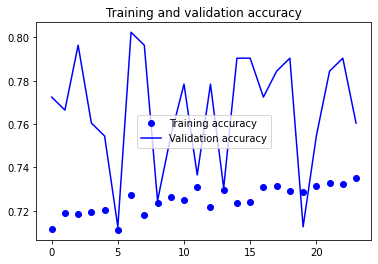

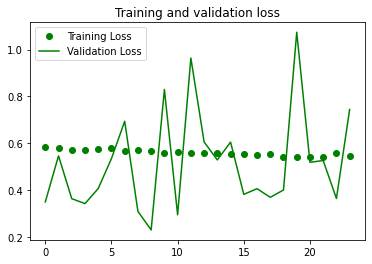

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1)

rootPath = '/content/gdrive/MyDrive/Study/collars_500x600_crop'
img_size = (100, 50)

imageGenerator = ImageDataGenerator(
    rescale=1. / 255,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[.2, .2],
    horizontal_flip=True,
)

trainGen = imageGenerator.flow_from_directory(os.path.join(rootPath, 'train'), class_mode='categorical',
                                              target_size=img_size, shuffle=True,
                                              color_mode='rgba')

valGenerator = ImageDataGenerator(rescale=1. / 255)

valGen = valGenerator.flow_from_directory(os.path.join(rootPath, 'val'), class_mode='categorical',
                                          target_size=img_size, shuffle=True,
                                          color_mode='rgba')

testGenerator = ImageDataGenerator(rescale=1. / 255)

testGen = testGenerator.flow_from_directory(os.path.join(rootPath, 'test'), class_mode='categorical',
                                            target_size=img_size, shuffle=True,
                                            color_mode='rgba')

# x, y = trainGen.next()
# print(x[0].shape)
# plt.imshow(x[0])
# plt.show()
# SE_block
def SE_block(pre_layer, ch, r):
    # Squeeze
    x = GlobalAveragePooling2D()(pre_layer)
    # Excitation
    x = Dense(int(ch/r), activation='relu')(x)
    x = Dense(ch, activation='sigmoid')(x)
    x = Reshape((1, 1, ch))(x)
    x = multiply([pre_layer, x])

    return x

inputs = Input(shape=(img_size + (4,)))
x = Conv2D(32, (3, 3), strides=(1, 1), padding='same', activation = 'relu')(inputs)
x = SE_block(x, 32, 4)
x = MaxPooling2D(pool_size = (2, 2))(x)
x = Conv2D(64, (3, 3), strides=(1, 1), padding='same', activation = 'relu')(x)
x = SE_block(x, 64, 16)
x = MaxPooling2D(pool_size = (2, 2))(x)
x = Flatten()(x)
x = Dense(128, activation = 'relu')(x)

outputs = Dense(3, activation = 'softmax')(x)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

epochs = 30
history = model.fit_generator(trainGen,
                              epochs=epochs,
                              steps_per_epoch=trainGen.samples / epochs * 5,
                              validation_data=valGen,
                              validation_steps=valGen.samples / epochs,
                              callbacks=[early_stopping])


print("\n Valid Accuracy: %.4f" % (model.evaluate_generator(valGen)[1]))
print("\n Test Accuracy: %.4f" % (model.evaluate_generator(testGen)[1]))

# graph
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'go', label='Training Loss')
plt.plot(epochs, val_loss, 'g', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

model.save('/content/gdrive/MyDrive/Study/model/model_cnn-senet/cnn_senet_alpha_all4.h5')

In [ ]:
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           (None, 100, 50, 4)   0                                            
__________________________________________________________________________________________________
conv2d_64 (Conv2D)              (None, 98, 48, 32)   1184        input_21[0][0]                   
__________________________________________________________________________________________________
global_average_pooling2d_26 (Gl (None, 32)           0           conv2d_64[0][0]                  
__________________________________________________________________________________________________
dense_103 (Dense)               (None, 4)            132         global_average_pooling2d_26[0][0]
___________________________________________________________________________________________

#**500X600**

- img_size = (125, 150)

- 투명

Found 1345 images belonging to 3 classes.
Found 167 images belonging to 3 classes.
Found 167 images belonging to 3 classes.
Epoch 1/30
225/224 [==============================] - 516s 2s/step - loss: 0.9164 - acc: 0.5637 - val_loss: 1.2181 - val_acc: 0.5689
Epoch 2/30
225/224 [==============================] - 117s 520ms/step - loss: 0.8931 - acc: 0.5753 - val_loss: 0.8709 - val_acc: 0.5689
Epoch 3/30
225/224 [==============================] - 116s 517ms/step - loss: 0.8451 - acc: 0.5977 - val_loss: 1.0484 - val_acc: 0.6228
Epoch 4/30
225/224 [==============================] - 117s 519ms/step - loss: 0.7602 - acc: 0.6393 - val_loss: 0.5816 - val_acc: 0.6886
Epoch 5/30
225/224 [==============================] - 115s 513ms/step - loss: 0.7012 - acc: 0.6713 - val_loss: 0.8627 - val_acc: 0.6108
Epoch 6/30
225/224 [==============================] - 115s 512ms/step - loss: 0.6861 - acc: 0.6846 - val_loss: 0.8123 - val_acc: 0.6287
Epoch 7/30
225/224 [==============================] - 115s 509m

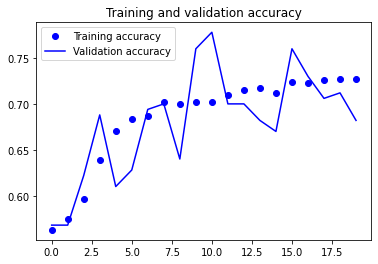

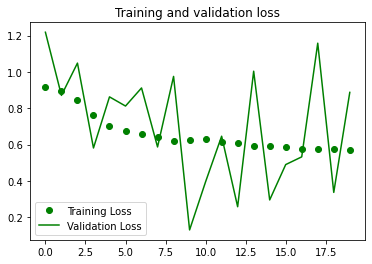

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

rootPath = '/content/gdrive/MyDrive/Study/collars_500x600'
img_size = (125, 150)

imageGenerator = ImageDataGenerator(
    rescale=1. / 255,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[.2, .2],
    horizontal_flip=True,
)

trainGen = imageGenerator.flow_from_directory(os.path.join(rootPath, 'train'), class_mode='categorical',
                                              target_size=img_size, shuffle=True,
                                              color_mode='rgba')

valGenerator = ImageDataGenerator(rescale=1. / 255)

valGen = valGenerator.flow_from_directory(os.path.join(rootPath, 'val'), class_mode='categorical',
                                          target_size=img_size, shuffle=True,
                                          color_mode='rgba')

testGenerator = ImageDataGenerator(rescale=1. / 255)

testGen = testGenerator.flow_from_directory(os.path.join(rootPath, 'test'), class_mode='categorical',
                                            target_size=img_size, shuffle=True,
                                            color_mode='rgba')

# x, y = trainGen.next()
# print(x[0].shape)
# plt.imshow(x[0])
# plt.show()

model = Sequential()

model.add(InputLayer(input_shape=(img_size + (4,))))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

epochs = 30
history = model.fit_generator(trainGen,
                              epochs=epochs,
                              steps_per_epoch=trainGen.samples / epochs * 5,
                              validation_data=valGen,
                              validation_steps=valGen.samples / epochs,
                              callbacks=[early_stopping])

print("\n Valid Accuracy: %.4f" % (model.evaluate_generator(valGen)[1]))
print("\n Test Accuracy: %.4f" % (model.evaluate_generator(testGen)[1]))

# graph
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'go', label='Training Loss')
plt.plot(epochs, val_loss, 'g', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

model.save('/content/gdrive/MyDrive/Study/model/model_cnn-senet/cnn_alpha_BIG.h5') 

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 123, 148, 32)      1184      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 61, 74, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 61, 74, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 59, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 29, 36, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 29, 36, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 27, 34, 128)      

- 검정

Found 1345 images belonging to 3 classes.
Found 167 images belonging to 3 classes.
Found 167 images belonging to 3 classes.
Epoch 1/30
225/224 [==============================] - 384s 2s/step - loss: 0.9206 - acc: 0.5618 - val_loss: 1.4718 - val_acc: 0.5689
Epoch 2/30
225/224 [==============================] - 59s 264ms/step - loss: 0.9028 - acc: 0.5675 - val_loss: 2.4713 - val_acc: 0.5569
Epoch 3/30
225/224 [==============================] - 59s 263ms/step - loss: 0.8940 - acc: 0.5666 - val_loss: 0.6307 - val_acc: 0.5689
Epoch 4/30
225/224 [==============================] - 59s 263ms/step - loss: 0.8424 - acc: 0.5899 - val_loss: 0.7928 - val_acc: 0.6407
Epoch 5/30
225/224 [==============================] - 59s 263ms/step - loss: 0.7784 - acc: 0.6258 - val_loss: 1.1904 - val_acc: 0.6228
Epoch 6/30
225/224 [==============================] - 59s 263ms/step - loss: 0.7692 - acc: 0.6336 - val_loss: 0.6954 - val_acc: 0.6407
Epoch 7/30
225/224 [==============================] - 59s 263ms/step

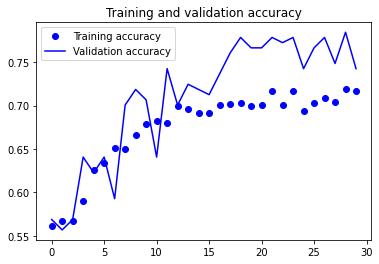

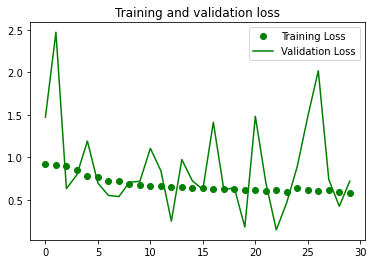

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

rootPath = '/content/gdrive/MyDrive/Study/mask_collars_500x600'
img_size = (125, 150)

imageGenerator = ImageDataGenerator(
    rescale=1. / 255,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[.2, .2],
    horizontal_flip=True,
)

trainGen = imageGenerator.flow_from_directory(os.path.join(rootPath, 'train'), class_mode='categorical',
                                              target_size=img_size, shuffle=True)

valGenerator = ImageDataGenerator(rescale=1. / 255)

valGen = valGenerator.flow_from_directory(os.path.join(rootPath, 'val'), class_mode='categorical',
                                          target_size=img_size, shuffle=True)

testGenerator = ImageDataGenerator(rescale=1. / 255)

testGen = testGenerator.flow_from_directory(os.path.join(rootPath, 'test'), class_mode='categorical',
                                            target_size=img_size, shuffle=True)

# x, y = trainGen.next()
# print(x[0].shape)
# plt.imshow(x[0])
# plt.show()

model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape = (125, 150, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

epochs = 30
history = model.fit_generator(trainGen,
                              epochs=epochs,
                              steps_per_epoch=trainGen.samples / epochs * 5,
                              validation_data=valGen,
                              validation_steps=valGen.samples / epochs,
                              callbacks=[early_stopping])

print("\n Valid Accuracy: %.4f" % (model.evaluate_generator(valGen)[1]))
print("\n Test Accuracy: %.4f" % (model.evaluate_generator(testGen)[1]))

# graph
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'go', label='Training Loss')
plt.plot(epochs, val_loss, 'g', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

model.save('/content/gdrive/MyDrive/Study/model/model_cnn-senet/cnn_mask.h5') 

Found 1345 images belonging to 3 classes.
Found 167 images belonging to 3 classes.
Found 167 images belonging to 3 classes.
Epoch 1/30
225/224 [==============================] - 345s 2s/step - loss: 0.9186 - acc: 0.5595 - val_loss: 1.8926 - val_acc: 0.5629
Epoch 2/30
225/224 [==============================] - 62s 277ms/step - loss: 0.9112 - acc: 0.5667 - val_loss: 1.9673 - val_acc: 0.5629
Epoch 3/30
225/224 [==============================] - 62s 277ms/step - loss: 0.8852 - acc: 0.5727 - val_loss: 1.5505 - val_acc: 0.5269
Epoch 4/30
225/224 [==============================] - 62s 275ms/step - loss: 0.8527 - acc: 0.5875 - val_loss: 0.5566 - val_acc: 0.5808
Epoch 5/30
225/224 [==============================] - 62s 276ms/step - loss: 0.7826 - acc: 0.6241 - val_loss: 1.1971 - val_acc: 0.6048
Epoch 6/30
225/224 [==============================] - 62s 275ms/step - loss: 0.7267 - acc: 0.6410 - val_loss: 0.4943 - val_acc: 0.6587
Epoch 7/30
225/224 [==============================] - 62s 276ms/step

/usr/local/lib/python3.7/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 1 could not be retrieved. It could be because a worker has died.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 3 could not be retrieved. It could be because a worker has died.
  UserWarning)



 Test Accuracy: 0.7305


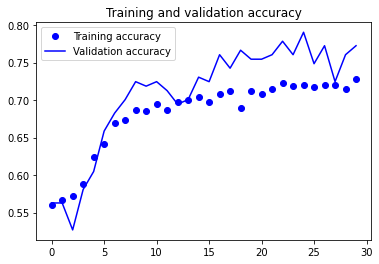

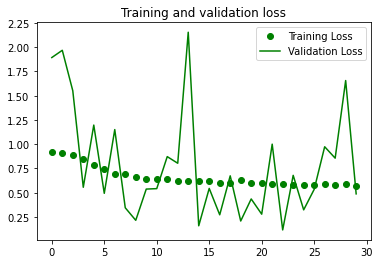

In [7]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

rootPath = '/content/gdrive/MyDrive/Study/mask_collars_500x600'
img_size = (125, 150)

imageGenerator = ImageDataGenerator(
    rescale=1. / 255,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[.2, .2],
    horizontal_flip=True,
)

trainGen = imageGenerator.flow_from_directory(os.path.join(rootPath, 'train'), class_mode='categorical',
                                              target_size=img_size, shuffle=True)

valGenerator = ImageDataGenerator(rescale=1. / 255)

valGen = valGenerator.flow_from_directory(os.path.join(rootPath, 'val'), class_mode='categorical',
                                          target_size=img_size, shuffle=True)

testGenerator = ImageDataGenerator(rescale=1. / 255)

testGen = testGenerator.flow_from_directory(os.path.join(rootPath, 'test'), class_mode='categorical',
                                            target_size=img_size, shuffle=True)

# x, y = trainGen.next()
# print(x[0].shape)
# plt.imshow(x[0])
# plt.show()

model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape = (125, 150, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

epochs = 30
history = model.fit_generator(trainGen,
                              epochs=epochs,
                              steps_per_epoch=trainGen.samples / epochs * 5,
                              validation_data=valGen,
                              validation_steps=valGen.samples / epochs,
                              callbacks=[early_stopping])

print("\n Valid Accuracy: %.4f" % (model.evaluate_generator(valGen)[1]))
print("\n Test Accuracy: %.4f" % (model.evaluate_generator(testGen)[1]))

# graph
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'go', label='Training Loss')
plt.plot(epochs, val_loss, 'g', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

model.save('/content/gdrive/MyDrive/Study/model/model_cnn-senet/cnn_mask2.h5') 

In [8]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 123, 148, 32)      896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 61, 74, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 61, 74, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 59, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 29, 36, 64)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 29, 36, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 27, 34, 128)      

- 흰색

Found 1345 images belonging to 3 classes.
Found 167 images belonging to 3 classes.
Found 167 images belonging to 3 classes.
Epoch 1/30
225/224 [==============================] - 499s 2s/step - loss: 0.9338 - acc: 0.5645 - val_loss: 0.7644 - val_acc: 0.5689
Epoch 2/30
225/224 [==============================] - 59s 264ms/step - loss: 0.9284 - acc: 0.5627 - val_loss: 0.8887 - val_acc: 0.5689
Epoch 3/30
225/224 [==============================] - 59s 264ms/step - loss: 0.9162 - acc: 0.5689 - val_loss: 0.9120 - val_acc: 0.5689
Epoch 4/30
225/224 [==============================] - 60s 266ms/step - loss: 0.9153 - acc: 0.5643 - val_loss: 0.7936 - val_acc: 0.5689
Epoch 5/30
225/224 [==============================] - 59s 262ms/step - loss: 0.9158 - acc: 0.5648 - val_loss: 0.7983 - val_acc: 0.5689
Epoch 6/30
225/224 [==============================] - 60s 265ms/step - loss: 0.9159 - acc: 0.5671 - val_loss: 0.7169 - val_acc: 0.5689
Epoch 7/30
225/224 [==============================] - 60s 265ms/step

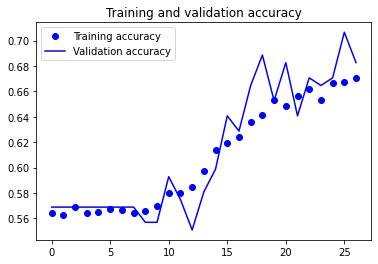

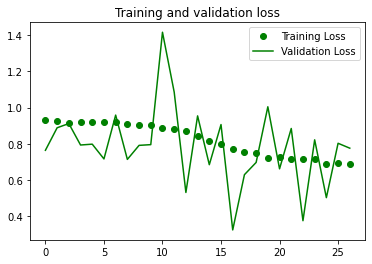

In [4]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

rootPath = '/content/gdrive/MyDrive/Study/white_collars_500x600'
img_size = (125, 150)

imageGenerator = ImageDataGenerator(
    rescale=1. / 255,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[.2, .2],
    horizontal_flip=True,
)

trainGen = imageGenerator.flow_from_directory(os.path.join(rootPath, 'train'), class_mode='categorical',
                                              target_size=img_size, shuffle=True)

valGenerator = ImageDataGenerator(rescale=1. / 255)

valGen = valGenerator.flow_from_directory(os.path.join(rootPath, 'val'), class_mode='categorical',
                                          target_size=img_size, shuffle=True)

testGenerator = ImageDataGenerator(rescale=1. / 255)

testGen = testGenerator.flow_from_directory(os.path.join(rootPath, 'test'), class_mode='categorical',
                                            target_size=img_size, shuffle=True)

# x, y = trainGen.next()
# print(x[0].shape)
# plt.imshow(x[0])
# plt.show()

model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape = (125, 150, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

epochs = 30
history = model.fit_generator(trainGen,
                              epochs=epochs,
                              steps_per_epoch=trainGen.samples / epochs * 5,
                              validation_data=valGen,
                              validation_steps=valGen.samples / epochs,
                              callbacks=[early_stopping])

print("\n Valid Accuracy: %.4f" % (model.evaluate_generator(valGen)[1]))
print("\n Test Accuracy: %.4f" % (model.evaluate_generator(testGen)[1]))

# graph
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'go', label='Training Loss')
plt.plot(epochs, val_loss, 'g', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

model.save('/content/gdrive/MyDrive/Study/model/model_cnn-senet/cnn_white.h5') 

In [5]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 123, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 61, 74, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 61, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 59, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 29, 36, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 29, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 27, 34, 128)      